In [3]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import os
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import mutual_info_regression
import scipy.stats as stats
from scipy.stats import ttest_ind







In [4]:
from pathlib import Path
import pandas as pd


user = 'alilodhi'

figure_path = f'/Users/{user}/Downloads/UVAmacro-main/post_4/figures'


# Define the path to the directory containing the CSV files
data_path = Path(f'/Users/{user}/Downloads/UVAmacro-main/post_4/data')


df_OIS_swaps = pd.read_csv(f'{data_path}/OIS_swap_rates.csv')

df_treasury_yields = pd.read_csv(f'{data_path}/treasury_yields.csv')

df_tp = pd.read_csv(f'{data_path}/ACM.csv')

df_tp = df_tp[['Date', 'ACMTP10']]

df_tp.rename(columns={'ACMTP10': '10yr_tp'}, inplace=True)

df_tp['Date'] = pd.to_datetime(df_tp['Date'])

df_OIS_swaps['Date'] = pd.to_datetime(df_OIS_swaps['Date'])

df_treasury_yields['Date'] = pd.to_datetime(df_treasury_yields['Date'])

df_total = pd.merge(df_OIS_swaps, df_treasury_yields, on='Date', how='inner')

df_total = pd.merge(df_total, df_tp, on='Date', how='inner')

df_total.rename(columns={'7yr_yield ': '7yr_yield'}, inplace=True)
df_total.sort_values(by='Date', ascending=True, inplace=True)
df_total.reset_index(drop=True, inplace=True)

df_total['10yr_tp'] = df_total['10yr_tp']*100

df_total['2yr_OIS_swap'] = df_total['2yr_OIS_swap']*1000
df_total['10yr_OIS_swap'] = df_total['10yr_OIS_swap']*1000


print(df_total.columns)



Index(['Date', '3m_OIS_swap', '6m_OIS_swap', '1yr_OIS_swap', '2yr_OIS_swap',
       '3yr_OIS_swap', '5yr_OIS_swap', '7yr_OIS_swap', '10yr_OIS_swap',
       '10yr_yield', '1yr_yield', '2yr_yield', '5yr_yield', '30yr_yield',
       '20yr_yield', '3yr_yield', '7yr_yield', '10yr_tp'],
      dtype='object')


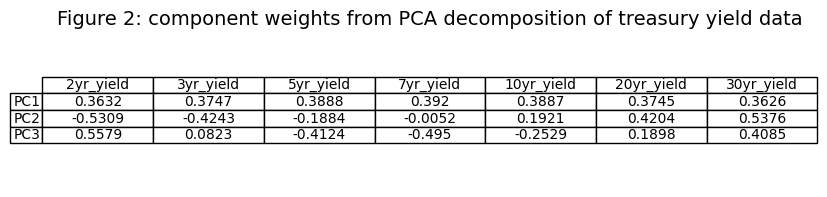

In [14]:
# figure 2 

# Define the function to plot PCA component weights as a table
def plot_pca_component_weights(pca, feature_names, title="PCA Component Weights", figure_path=None):
    """
    Plots a table of PCA component weights and saves it to a file if figure_path is provided.
    
    Parameters:
    pca: Fitted PCA object
    feature_names: List of feature names corresponding to components
    title: Custom title for the table
    figure_path: Path to save the figure (optional)
    """
    component_weights = pd.DataFrame(pca.components_, columns=feature_names, index=[f'PC{i+1}' for i in range(pca.n_components_)])
    


    fig, ax = plt.subplots(figsize=(10, 2))
    ax.axis('tight')
    ax.axis('off')
    ax.table(cellText=component_weights.round(4).values,
             colLabels=component_weights.columns,
             rowLabels=component_weights.index,
             cellLoc='center', loc='center')
    
    plt.title(title, fontsize=14)

    # Save to file if figure_path is specified
    if figure_path:
        plt.savefig(figure_path)

    plt.show()
    
# Define PCA columns
pca_columns = ['2yr_yield', '3yr_yield', '5yr_yield', '7yr_yield', '10yr_yield', '20yr_yield', '30yr_yield']

# Standardize the data
df_pca = df_total[pca_columns].dropna()  # Drop NaN values to ensure PCA works
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_pca)

# Perform PCA
pca = PCA(n_components=3)
pc_scores = pca.fit_transform(df_scaled)  # Get PC1, PC2 values

# Merge PC scores (PC1, PC2) back into df_total
df_total['PC1'] = pc_scores[:, 0]
df_total['PC2'] = pc_scores[:, 1]
df_total['PC3'] = pc_scores[:, 2]



# Define figure path (ensure the directory exists)
figure_with_name = os.path.join(figure_path, 'figure_2.jpg')

# Plot and save PCA component weights
plot_pca_component_weights(pca, pca_columns, title="Figure 2: component weights from PCA decomposition of treasury yield data", figure_path=figure_with_name)





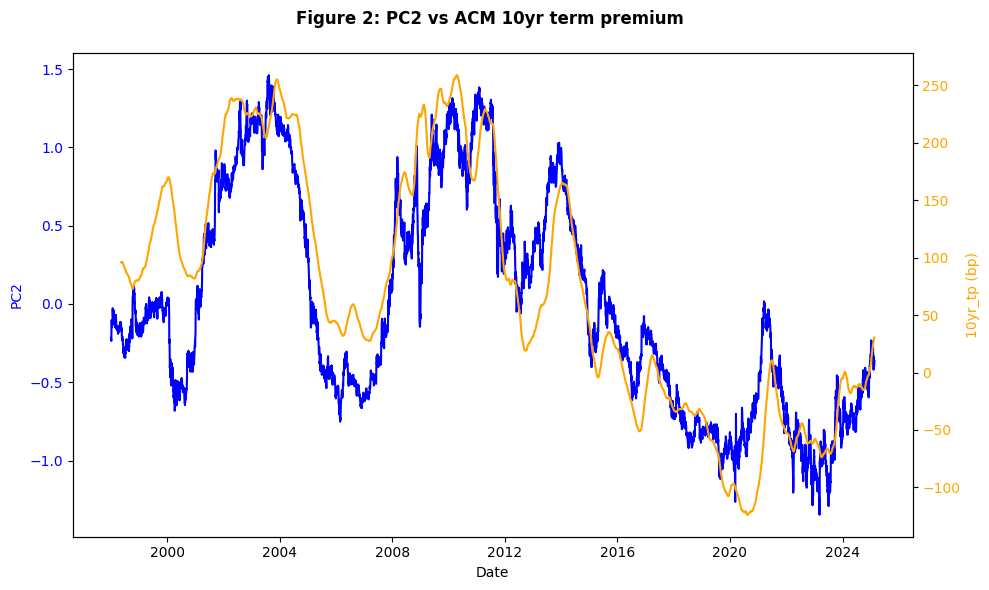

In [6]:
# figure 3


fig, ax1 = plt.subplots(figsize=(10, 6))

df_total['PC2_sm'] = df_total['PC2'].rolling(window=90).mean()
df_total['10yr_tp_sm'] = df_total['10yr_tp'].rolling(window=90).mean()

# Plot PC2 on primary y-axis
ax1.plot(df_total['Date'], df_total['PC2'], label='PC2', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('PC2', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(df_total['Date'], df_total['10yr_tp_sm'], label='10yr_tp', color='orange')
ax2.set_ylabel('10yr_tp (bp)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Title and formatting
plt.title('Figure 2: PC2 vs ACM 10yr term premium \n', fontweight='bold')
fig.tight_layout()
fig.savefig(f'{figure_path}/figure_3.jpg', format='jpeg', bbox_inches='tight')
plt.show()





89     1998-05-12
90     1998-05-13
91     1998-05-14
92     1998-05-15
93     1998-05-18
          ...    
6772   2025-02-11
6773   2025-02-12
6774   2025-02-13
6775   2025-02-14
6776   2025-02-18
Name: Date, Length: 6688, dtype: datetime64[ns]
PCA loadings table saved as: /Users/alilodhi/Downloads/UVAmacro-main/post_4/figures/figure_3.jpg


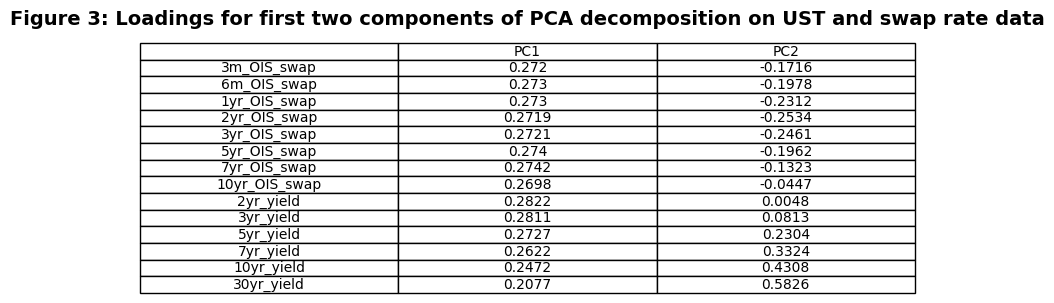

In [22]:
# figure 4
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

print(df_total.Date)


df_total['spread_10yr_2yr'] = df_total['10yr_OIS_swap'] - df_total['10yr_yield'] - (df_total['2yr_OIS_swap'] - df_total['2yr_yield'])
# Spread of spreads for each tenor
df_total['spread_10yr_1yr'] = df_total['10yr_OIS_swap'] - df_total['10yr_yield'] - (df_total['1yr_OIS_swap'] - df_total['1yr_yield'])


pca_columns = [
    '3m_OIS_swap', '6m_OIS_swap', '1yr_OIS_swap', '2yr_OIS_swap', 
    '3yr_OIS_swap', '5yr_OIS_swap', '7yr_OIS_swap', '10yr_OIS_swap',
    '2yr_yield', '3yr_yield', '5yr_yield', 
    '7yr_yield', '10yr_yield', '30yr_yield'
]






# Drop missing data for these columns
df_pca = df_total[pca_columns].dropna()

# Optional: Drop missing values in the entire dataframe (but avoid removing these rows prematurely)
df_total.dropna(inplace=True)

# Step 2: Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_pca)

# Step 3: Perform PCA (number of components equal to the number of variables)
n_components = 2  # Set the number of components equal to the number of variables
pca = PCA(n_components=n_components)
pc_scores = pca.fit_transform(df_scaled)

# Step 4: Merge the PCA components into the original dataframe as new columns
for i in range(n_components):
    df_total[f'PC{i+1}'] = pc_scores[:, i]




# Optional: Drop missing values from the original dataframe (if any introduced by PCA scores)
df_total.dropna(inplace=True)

# Step 5: Extract Loadings
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(n_components)], index=pca_columns)



import matplotlib.pyplot as plt
import os

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 3))
ax.axis('tight')
ax.axis('off')

# Create table
table_data = loadings_table.reset_index().values  # Convert DataFrame to list format for table
column_labels = ['','PC1', 'PC2']  # Column names

table = ax.table(cellText=table_data, colLabels=column_labels, cellLoc='center', loc='center')
plt.title('Figure 3: Loadings for first two components of PCA decomposition on UST and swap rate data', fontsize=14, fontweight='bold', pad=20)

# Save table as JPEG
table_path = os.path.join(figure_path, 'figure_3.jpg')
plt.savefig(table_path, dpi=300, bbox_inches='tight')

print(f"PCA loadings table saved as: {table_path}")







/Users/alilodhi/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


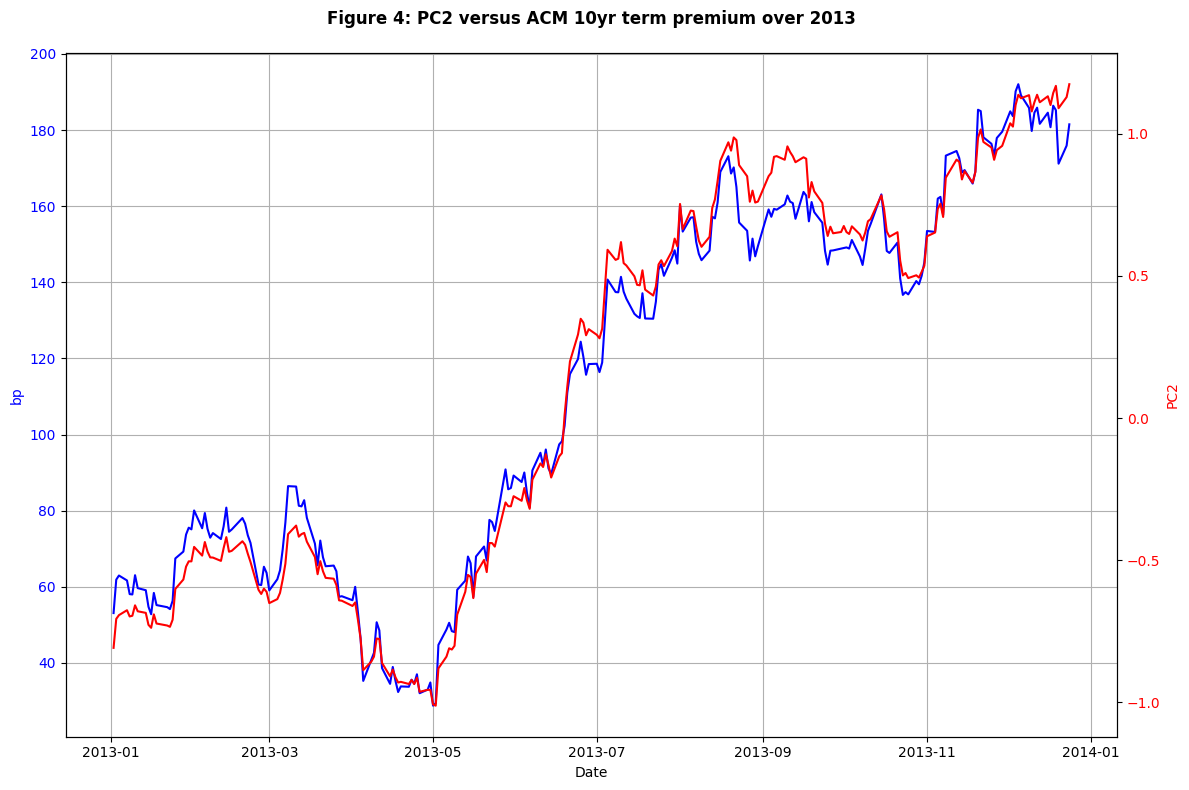

In [24]:
#figure 4 

# Filter for 2007-2009

df_total['PC2_sm'] = df_total['PC2'].rolling(window=30).mean()
df_filtered = df_total[(df_total['Date'] >= '2013-01-01') & (df_total['Date'] <= '2013-12-25')]


# Create the figure and axis
fig, ax1 = plt.subplots(figsize=(12, 8))
df_filtered['spread2'] = (df_filtered['10yr_OIS_swap'] - df_filtered['10yr_yield']) 


# Plot PC2 on the first y-axis (ax1)
ax1.plot(df_filtered['Date'], df_filtered['10yr_tp'], color='blue', label='other')
ax1.set_xlabel('Date')
ax1.set_ylabel('bp', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot PC1 on the second y-axis (ax2)
ax2.plot(df_filtered['Date'], df_filtered['PC2'], color='red', label='PC2')
ax2.set_ylabel('PC2', color='red')
ax2.tick_params(axis='y', labelcolor='red')

#ax2.axvspan('2025-02-22', '2013-11-27', color='grey', alpha=0.3)

# Title and grid
plt.title('Figure 4: PC2 versus ACM 10yr term premium over 2013, year of the Taper Tantrum \n', fontweight = 'bold')
ax1.grid(True)

# Show the plot
plt.tight_layout()
plt.savefig(f'{figure_path}/figure_4.jpg', format='jpeg', bbox_inches='tight')

plt.show()


/Users/alilodhi/Library/Python/3.7/lib/python/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


6770   -1.273411
Name: PC2_5d_zscore, dtype: float64


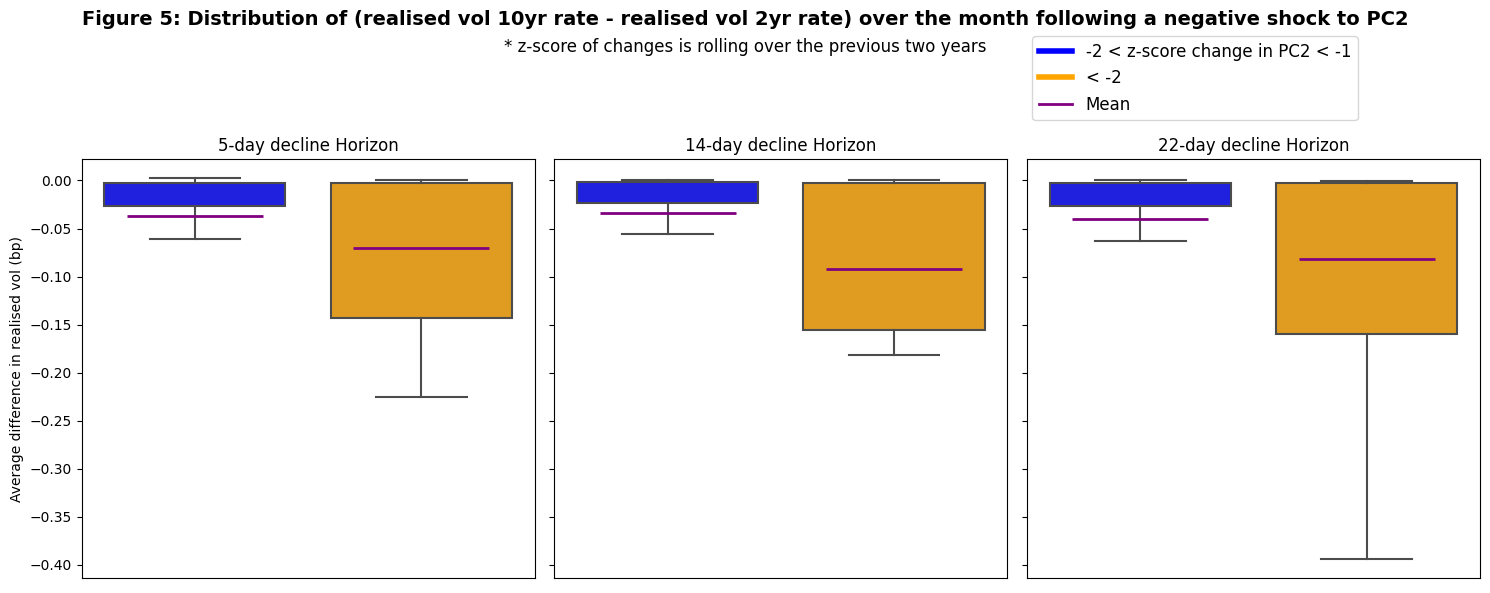

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure Date column is a datetime type
df_total['Date'] = pd.to_datetime(df_total['Date'])



df_total['10yr_returns'] = np.log(df_total['10yr_OIS_swap']/ df_total['10yr_OIS_swap'].shift(1))
df_total['2yr_returns'] = np.log(df_total['2yr_OIS_swap']/ df_total['2yr_OIS_swap'].shift(1))

df_total['10yr_vol'] = df_total['10yr_returns'].rolling(window=30).std()
df_total['2yr_vol'] = df_total['2yr_returns'].rolling(window=30).std()

df_total['vol_diff'] = df_total['10yr_vol'] - df_total['2yr_vol']



# Define thresholds for PC2 shocks
thresholds = [[-2, -1], [-np.inf, -2]]  # PC2 < 0, -2 < PC2 < -1, and PC2 < -2

# Compute rolling changes in PC2 for different periods
df_total['PC2_5d_change'] = df_total['PC2'].diff(5)  
df_total['PC2_14d_change'] = df_total['PC2'].diff(14)  
df_total['PC2_22d_change'] = df_total['PC2'].diff(22)  

# Compute rolling mean and standard deviation for z-score calculation
rolling_window = 500  # One year of trading days

df_total['PC2_5d_zscore'] = (df_total['PC2_5d_change'] - df_total['PC2_5d_change'].rolling(rolling_window, min_periods=1).mean()) / df_total['PC2_5d_change'].rolling(rolling_window, min_periods=1).std()
df_total['PC2_14d_zscore'] = (df_total['PC2_14d_change'] - df_total['PC2_14d_change'].rolling(rolling_window, min_periods=1).mean()) / df_total['PC2_14d_change'].rolling(rolling_window, min_periods=1).std()
df_total['PC2_22d_zscore'] = (df_total['PC2_22d_change'] - df_total['PC2_22d_change'].rolling(rolling_window, min_periods=1).mean()) / df_total['PC2_22d_change'].rolling(rolling_window, min_periods=1).std()


#last 5 days computation

print(df_total.loc[df_total['Date']=='2025-02-07', 'PC2_5d_zscore'])

# List to store results for box plot
boxplot_data = []

# Loop through different decline periods and thresholds
for period, z_col in zip([5, 14, 22], ['PC2_5d_zscore', 'PC2_14d_zscore', 'PC2_22d_zscore']):
    for lower, upper in thresholds:
        selected_dates = df_total.loc[(df_total[z_col] >= lower) & (df_total[z_col] < upper), 'Date']
        avg_vol_diffs = []
        
        for date in selected_dates:
            future_vol_diff = df_total.loc[(df_total['Date'] > date) & (df_total['Date'] <= date + pd.Timedelta(days=22)), 'vol_diff']
            if not future_vol_diff.empty:
                avg_vol_diffs.append(future_vol_diff.mean())
        
        # Store results for box plot
        threshold_label = f'{lower} < z-score change in PC2 < {upper}' if lower != -np.inf else f'< {upper}'
        for val in avg_vol_diffs:
            boxplot_data.append({'PC2 Decline Period': f'{period}-day decline', 
                                 'Threshold': threshold_label, 
                                 'avg_vol_diff': val})

# Convert to DataFrame
boxplot_df = pd.DataFrame(boxplot_data)

# Create separate subplots for each horizon
fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True)

# Define custom colors
colors = {"-2 < z-score change in PC2 < -1": "blue", "< -2": "orange"}

for ax, period in zip(axes, ['5-day decline', '14-day decline', '22-day decline']):
    # Draw standard boxplot
    sns.boxplot(x='Threshold', y='avg_vol_diff', data=boxplot_df[boxplot_df['PC2 Decline Period'] == period],
                showfliers=False, palette=colors, ax=ax, medianprops={"visible": False})
    
    # Compute means for each category
    means = boxplot_df[boxplot_df['PC2 Decline Period'] == period].groupby('Threshold')['avg_vol_diff'].mean()
    
    # Draw mean lines manually
    for i, mean_val in enumerate(means):
        ax.hlines(y=mean_val, xmin=i - 0.3, xmax=i + 0.3, color='purple', linewidth=2, label="Mean" if i == 0 else "")
    
    # Remove x-axis labels and ticks
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_xlabel('')
    
    ax.set_title(f'{period} Horizon')
    
    # Remove grid lines
    ax.grid(False)
    
    # Only leftmost plot gets the y-axis label
    if ax == axes[0]:
        ax.set_ylabel('Average difference in realised vol (bp)')
    else:
        ax.set_ylabel('')

# Add title
plt.suptitle("Figure 5: Distribution of (realised vol 10yr rate - realised vol 2yr rate) over the month following a negative shock to PC2\n\n\n",
             fontsize=14, fontweight='bold')

# Add a body of text below the main title
plt.figtext(0.5, 0.91, 
            "* z-score of changes is rolling over the previous two years"
, 
            fontsize=12, ha="center")
# Add legend
legend_labels = [plt.Line2D([0], [0], color=color, lw=4, label=label) for label, color in colors.items()]
legend_labels.append(plt.Line2D([0], [0], color='purple', lw=2, label='Mean'))
fig.legend(handles=legend_labels, loc="upper center", bbox_to_anchor=(0.8, 0.95), fontsize=12, ncol=1)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to accommodate title

plt.savefig(f'{figure_path}/figure_5.jpg', format='jpeg', bbox_inches='tight')

plt.show()


# this one and then the on-hold mean reversion one and then the assymetric exposure to term premium because of flattness one 
